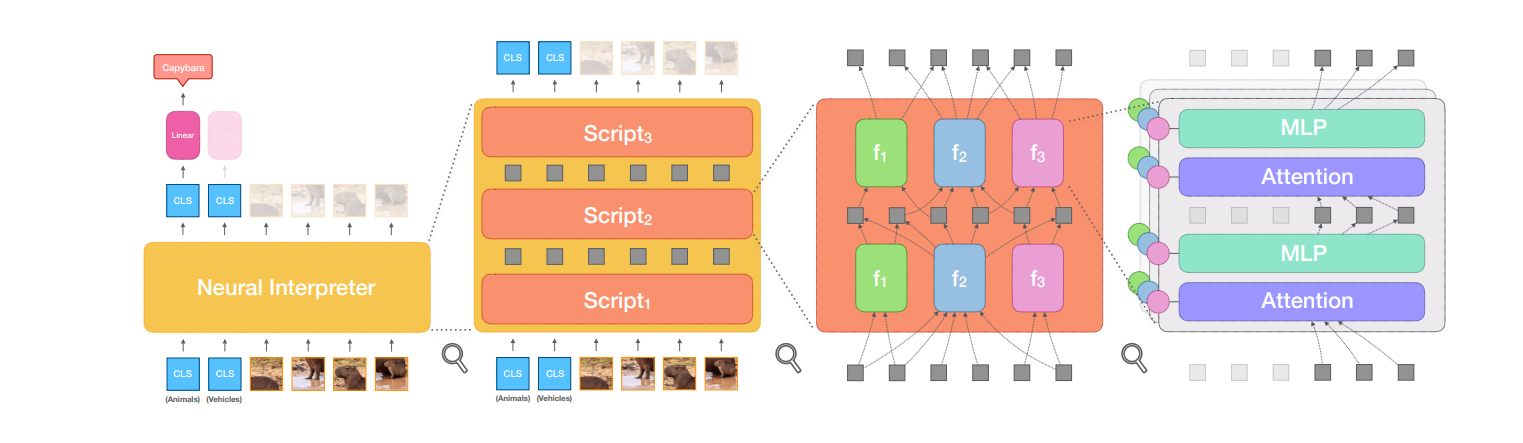

# Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
# Main Hyperparameters
img_size = 32                           # Dimension of spatial axes of input images
patch_size = 4                          # Patch size
in_channels = 3                         # Dimension of input channels
embed_dim = 256                         # Dimension of embeddings
batch_size = 128                        # Number of batch
epochs = 100                            # Number of epochs
dim_c = 192                             # Dimension of 'code' vector
dim_inter = 192                         # Dimension of intermediate feature vector
ns = 1                                  # Number of 'scripts'
ni = 8                                  # Number of 'function' iterations
nl = 1                                  # Number of LOCs
nf = 5                                  # Number of 'function's
n_cls = 3                               # Number of CLS tokens
n_heads = 4                             # Number of heads per LOC
loc_features = 128                      # Number of features per LOC head
type_inference_depth = 2                # Type Inference MLP depth
type_inference_width = 192              # Type Inference MLP width 
treshold = 1.4                          # Trunctation Parameter
signature_dim = 24                      # Dimension of type_space = dtype

# Pretraining Hyperparameters # Dimension of input channels
frozen_function_codes = False           # Required for pretraining
frozen_function_signatures = False      # Required for pretraining

# Optimization Hyperparameters          
beta1 = 0.9                             # Adam Optimizer beta1 parameter
beta2 = 0.999                           # Adam Optimizer beta2 parameter
lr = 1e-8                               # Learning Rate

# Dataloader 

In [3]:
def get_data_loader(datasetname, root, batch_size, transform):
  '''
  Digits dataset is a combination of three related datasets:
      1. SVHN 
      2. MNISTM   -> RESIZE all of them to [32 x 32]
      3. MNIST
  '''
  if datasetname == 'digits':
    # Get the dataset
    svhn = datasets.SVHN(root=root, 
                         split='train',
                         download=True,
                         transform=transform)
    # Get the loader
    loader = DataLoader(
        svhn,
        batch_size = batch_size,
        num_workers = 2,
        pin_memory = True,
        shuffle= True
    )

  return loader

In [4]:
# Parameters for dataset
datasetname = 'digits'
root = '.'
batch_size = 128
transform = transforms.Compose([
                  transforms.Resize((32, 32)),
                  transforms.ToTensor()])
loader = get_data_loader(datasetname, root, batch_size, transform)

  0%|          | 0/182040794 [00:00<?, ?it/s]

In [5]:
data = next(iter(loader))

In [6]:
print('data[0]:', data[0].size())
print('data[1]:', data[1].size())

data[0]: torch.Size([128, 3, 32, 32])
data[1]: torch.Size([128])


In [7]:
def visualize_data(loader):
  # Get a sample of data
  samples = next(iter(loader))[0]
  
  # Determine grid size
  grid_width = 8 
  grid_height = 8
  
  # Create the grid
  image_grid = make_grid(samples[:grid_width*grid_height], nrow=grid_width)
  
  # Visualization arrangement
  plt.rcParams['figure.figsize'] = [grid_height, grid_width]
  plt.imshow(image_grid.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

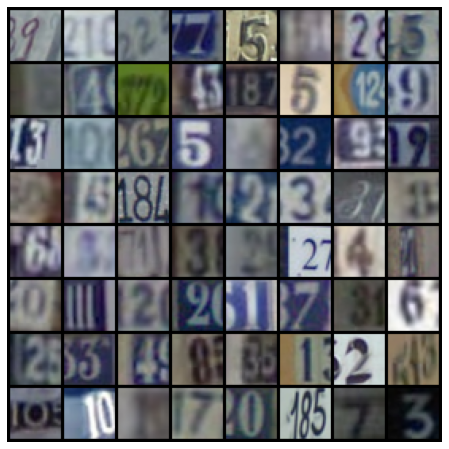

In [8]:
visualize_data(loader)

# Patch Embedding

In [9]:
class PatchEmbedding(nn.Module):
  '''
  Given images are linearly embedded via Patch Embedding in order to get tokens.

  Args:
  -----  
    img_size    [int]: Images are assumed to be square
    patch_size  [int]: Images are divided into patches of size `patch size`
    in_channels [int]: Number of input channels of given images
    embed_dim   [int]: Final embedding dimension

  Attributes:
  -----------
    n_patches   [int]:  Number of total patches at the end
    projection  [Conv]: Patch extractor
  '''

  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.embed_dim = embed_dim
    
    self.n_patches = (img_size // patch_size) ** 2
    self.projection = nn.Conv2d(in_channels = in_channels, 
                                out_channels = embed_dim, 
                                kernel_size = patch_size, 
                                stride = patch_size)
  
  def forward(self, x):
    '''
    Args:
    -----
      x [Tensor(B x C x H x W)]: Input images
    
    Returns:
    --------
      projected [Tensor(B x N x E)] where N stands for n_patches & E stands for embed_dim
    '''
    projected = self.projection(x).flatten(2).transpose(1, 2) 
    return projected

In [18]:
# TEST
img = data[0]
print(img.shape)
patch_embedding = PatchEmbedding(img_size, 
                                 patch_size, 
                                 in_channels, 
                                 embed_dim)

embeddings = patch_embedding(img)
embeddings.size()

torch.Size([128, 3, 32, 32])


torch.Size([128, 64, 256])

In [32]:
patch_embedding.projection(img).flatten(2).transpose(1, 2).shape

torch.Size([128, 64, 256])

# MLP

In [38]:
class MLP(nn.Module):
  '''
  Type Inference MLP module. 
  
  Args:
  ----
    in_features     [int]: Dimension of input features and output features
    hidden_features [int]: Dimension of intermediate features which corresponds to mlp_width in the paper
    mlp_depth       [int]: Number of mlp-layers as mentioned in the paper
    out_features    [int]: Dimension of the signature which is dtype as in the paper
    activ           [nn.module]: Activation function, default GELU mentioned in the paper
  Returns:
  -------
    t [Tensor()]: Type vector
  '''
  def __init__(self, in_features, hidden_features, mlp_depth, out_features, activ=nn.GELU):
    super().__init__()
    net = \
        [
            [
                nn.Linear(in_features, hidden_features),
                activ(),
            ]
        ] + \
        [
            [
                nn.Linear(hidden_features, hidden_features),
                activ(),
            ]   for i in range(mlp_depth-1)
        ] + \
        [
            [
                nn.Linear(hidden_features, out_features),
            ]
        ]

    net = sum(net, [])
    self.net = nn.Sequential(*net)

  def forward(self, embeddings):
    '''
    Args:
    ----
      embeddings [Tensor(B x N x E)]: 

    Returns:
    --------
      type_vector [Tensor(B x N x S)] where S stands for signature dimension
    '''
    type_vector = self.net(embeddings)
    return type_vector 

In [39]:
# TEST
mlp = MLP(embed_dim, type_inference_width, type_inference_depth, signature_dim)
type_vectors = mlp(embeddings)
type_vectors.size()

torch.Size([128, 64, 24])

# TypeInference

In [44]:
class TypeMatching(nn.Module):
  '''
  Enables the learned routing of input set through functions.
    
    1. Given a set of element x_i, extract its type vector t_i
    2. Compute `Compatibility`
    3. If this compatibility is larger than treshold, permit f_u to access x_i.
  '''
  def __init__(self, in_features, hidden_features, mlp_depth, out_features, treshold):
    super().__init__()
    self.treshold = treshold
    self.type_inference = MLP(in_features, hidden_features, mlp_depth, out_features)
    self.sigma = nn.Parameter(torch.ones(1))

  def forward(self, x, s):
    '''
    Args:
    -----
      x [Tensor(B x N x E)]: Embeddings
      s [Tensor(F x S)]
    
    Attributes:
      t [Tensor(B x N x S)]
      compatilibity_score [Tensor(B x F x N)]: Parallelized computation score of compatibility score. F stands for # Functions.
      compatilibity_hat   [Tensor(B x F x N)]: Negative exponentiated version of compatibility score
    '''
    t = self.type_inference(x)
    compatibility_score = self.get_compatilibity_score(t, s).transpose(1, 2)
    compatibility_hat = torch.exp(-compatibility_score / self.sigma)
    return compatibility_hat

  def get_compatilibity_score(self, t, s):
    distance = (1 - t @ s.transpose(0, 1))
    return torch.where(distance > self.treshold, distance, torch.tensor(0, dtype=torch.float))


In [45]:
# TEST
s = torch.ones(nf, signature_dim) # (#num_funcs x #dtype)
type_matching = TypeMatching(embed_dim, type_inference_width, type_inference_depth, signature_dim, treshold)
# embeddings: (#tokens, #embed) =>typeinf => (#tokens, #dtype) => typematch => (#tokens, #funcs)
out = type_matching(embeddings, s) 
out.size()

torch.Size([128, 5, 64])

In [15]:
torch.zeros(1)

tensor([0.])

In [16]:
a = torch.rand(5, 4, 3) # [B x N x S]
b = torch.rand(6, 3)    # [F x S]
(a @ (b.transpose(0, 1))).size() # Expected: [B x N x F]

torch.Size([5, 4, 6])